## Ustilago maydis mabo code

Manuel Boßmann 13.07.2022 <br/>
file name: iUma22_mabo_feed_plot.ipynb <br/>
This code is for plotting the objective function over a feed from 0% to 100% acetate. The other feed component is glucose.

import alle necessary modules

In [2]:
import numpy as np
from os.path import join
from cobra.io import read_sbml_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date
Today = date.today().strftime('%y%m%d')
FigureType = 'svg'


In [3]:
def SimCosub(model, Exchange_dic, Objective=None):
    '''
    Simulating a model with multiple substrates

    Arguments:
    model: cobra model, iUma22
    Exchange_dic: dictionary, exchange reaction ID as keys and flux as values
    Objective (optional): string, reaction to be optimized

    Return:
    Flux table from model.optimize
    '''
    with model as model:
        # model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
        [setattr(model.reactions.get_by_id(key), 'lower_bound', -value) for key, value in Exchange_dic.items()]
        if Objective:
            model.objective = Objective # 'EX_itacon_e'
        Flux = model.optimize().fluxes
    return Flux


Run model iUma22.xml

In [4]:
#Choose either "1.0" iUma22.xml model or "1.1" iUma22v1.1.xml model version

ModelFile = join('..','model','iUma22v1.1.xml')
model=read_sbml_model(ModelFile)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


## Co-feeding

In [6]:
ExchDict

{'EX_ac_e': 3.96, 'EX_glc__D_e': 0.8799999999999999}

In [7]:
3.96*2/(3.96*2+0.88*6)

0.6

In [11]:
MaxGrowth = 60
CFlux = 13.2
# Acetate comes first, then glucose
SubFlux = [[ratio*CFlux/(2*100),(CFlux-ratio*CFlux/100)/6] for ratio in range(MaxGrowth+1)]
EXID = ['EX_ac_e','EX_glc__D_e']
# myGrowth = list()
gglcup = list()
gacup = list()
gbio = list()
iglcup = list()
iacup = list()
ibio = list()

for Feed in SubFlux:
    ExchDict = {EXID[i]:Feed[i] for i in range(len(EXID))}
    Fluxg = SimCosub(model, ExchDict)
    # Fluxi = SimCosub(model, ExchDict, 'EX_itacon_e')
    gglcup.append(Fluxg['EX_glc__D_e'])
    gacup.append(Fluxg['EX_ac_e'])
    gbio.append(Fluxg['BIOMASS_REACTION'])
    # iglcup.append(Fluxi['EX_glc__D_e'])
    # iacup.append(Fluxi['EX_ac_e'])
    # ibio.append(Fluxi['BIOMASS_REACTION'])

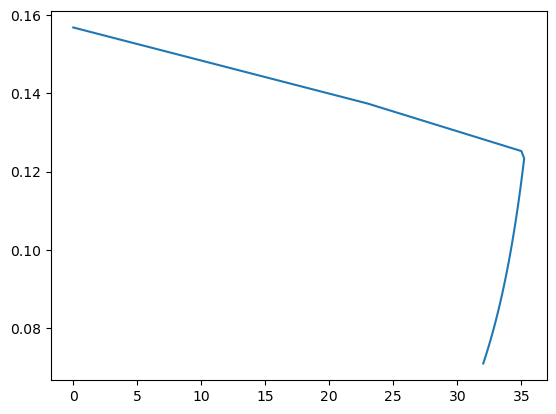

In [12]:
gAcRel = [gacup[i]*2/(gglcup[i]*6+gacup[i]*2)*100 for i in range(MaxGrowth+1)]
plt.plot(gAcRel, gbio)

choose 1 objective function

In [6]:
model.objective = "BIOMASS_REACTION"
# model.objective = "EX_itacon_e"

Run model from 0 to 100% acetate and output data to copy to excel

In [13]:
myres = list()
myita = list()
myrg = list()
myra = list()
myig = list()
myia = list()
total_c_flux = 13.2
# model.reactions.EX_glc__D_e.upper_bound = 0
# model.reactions.EX_glc__D_e.lower_bound = -100
# model.reactions.EX_ac_e.lower_bound = -100
# model.reactions.EX_ac_e.upper_bound = 0
for x in range(0,60,1):
    ac = round(x*total_c_flux/(2*100), 5)
    glc = round(1/6*(total_c_flux-2*ac), 4)

    #either set the feed via medium (#1) or set bounds directly (#2). Sometimes not all of the feed in the medium gets "consumed"
    #by setting upper and lower bound, the model is forced to use all feed
    #however, if it works setting by medium is preferred

    #1
    # medium = model.medium
    # medium['EX_ac_e']=ac
    # medium['EX_glc__D_e']=glc
    # model.medium = medium

    #2
    # model.reactions.EX_glc__D_e.upper_bound = -glc
    model.reactions.EX_glc__D_e.lower_bound = -glc
    model.reactions.EX_ac_e.lower_bound = -ac
    # model.reactions.EX_ac_e.upper_bound = -ac

    solution = model.optimize()
    myres.append(solution.objective_value)
    myrg.append(solution.fluxes['EX_glc__D_e'])
    myra.append(solution.fluxes['EX_ac_e'])

    with model as md:
        md.objective = "EX_itacon_e" 
        solita = md.optimize()
    myita.append(solita.objective_value)
    myig.append(solita.fluxes['EX_glc__D_e'])
    myia.append(solita.fluxes['EX_ac_e'])
    
    #for graph ita_cofeed
    # print(x, round(solution.fluxes.EX_itacon_e,3), round(-2*solution.fluxes.EX_ac_e/(-2*solution.fluxes.EX_ac_e-6*solution.fluxes.EX_glc__D_e)*100,3), sep="\t")

    #for graph growth rate
    #print(x, round(solution.fluxes.BIOMASS_REACTION,4), sep="\t")

    #for graph C-flux stacked bar chart
    #print(x, round(-solution.fluxes.EX_glc__D_e*6,3), round(-solution.fluxes.EX_ac_e*2,3), sep="\t")

In [15]:
relacg = np.array(myra)*2/(np.array(myra)*2+np.array(myrg)*6)
relaci = np.array(myia)*2/(np.array(myia)*2+np.array(myig)*6)
totalc = np.array(myra)*2+np.array(myrg)*6
itayield = -np.array(myita)*5/totalc

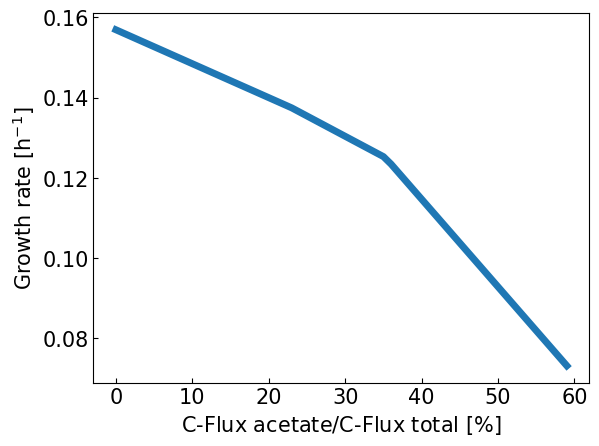

In [17]:
FigureName = 'AceRel-VS-GrowthRate'
matplotlib.rcParams.update({'font.size': 15})

plt.plot(relacg*100, myres, lw=5)
plt.xlabel('C-Flux acetate/C-Flux total [$\%$]')
plt.ylabel('Growth rate [h$^{-1}$]')
plt.tick_params(direction="in")
plt.savefig('{}_{}.pdf'.format(Today,FigureName,FigureType))

plt.show()

In [16]:
plot(relacg[:60]*100, itayield[:60], lw=5)

NameError: name 'plot' is not defined

This is just for testing stuff

In [ ]:
def test_cofeed(ac, glc):
    medium = model.medium
    medium['EX_ac_e']=ac
    medium['EX_glc__D_e']=glc
    model.medium = medium
    solution = model.optimize()
    print(solution.fluxes.BIOMASS_REACTION)
    return solution

In [ ]:
test_cofeed(0,1)
# test_cofeed(0.25,1)
# test_cofeed(0.5,1)
test_cofeed(1,1)